# Airline Passenger Satisfaction

## Importing libraries

In [75]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import learning_curve

## Formating to hide code

In [2]:
# Acknowledments to https://github.com/AxZxP

from IPython.display import HTML
import random
def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'
    toggle_text = 'Show/hide code'  
    target_cell = this_cell  
    js_hide_current = ''
    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'
    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))
    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}
            {js_hide_current}
        </script>
        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )
    return HTML(html)

hide_toggle()

## Importing data

In [120]:
airline_train = pd.read_csv("data/airline-train.csv")

## Understanding the data

In [4]:
airline_train.shape

(103904, 25)

In [5]:
airline_train.head(5)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [6]:
airline_train.dtypes

Unnamed: 0                             int64
id                                     int64
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure 

In [7]:
airline_train.nunique()

Unnamed: 0                           103904
id                                   103904
Gender                                    2
Customer Type                             2
Age                                      75
Type of Travel                            2
Class                                     3
Flight Distance                        3802
Inflight wifi service                     6
Departure/Arrival time convenient         6
Ease of Online booking                    6
Gate location                             6
Food and drink                            6
Online boarding                           6
Seat comfort                              6
Inflight entertainment                    6
On-board service                          6
Leg room service                          6
Baggage handling                          5
Checkin service                           6
Inflight service                          6
Cleanliness                               6
Departure Delay in Minutes      

In [8]:
# Checking if there's any duplicate row
airline_train[airline_train.duplicated()]

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction


## Data cleaning

In [9]:
# Droping column "Unnamed: 0" because it doesn't increment in my analysis:
airline_train.drop(columns="Unnamed: 0", inplace=True)

# Reseting index for "id" since these values are unique for each row:
airline_train.set_index("id", inplace=True)

# Gender : 1 for Female and 0 for Male
airline_train.Gender = airline_train.Gender.apply(lambda x: 1 if x=="Female" else 0)

airline_train.head(7)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
70172,0,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
5047,0,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
110028,1,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
24026,1,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
119299,0,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
111157,1,Loyal Customer,26,Personal Travel,Eco,1180,3,4,2,1,...,1,3,4,4,4,4,1,0,0.0,neutral or dissatisfied
82113,0,Loyal Customer,47,Personal Travel,Eco,1276,2,4,2,3,...,2,3,3,4,3,5,2,9,23.0,neutral or dissatisfied


In [10]:
# Sorting by the index, in order to have a cleaner structure
airline_train.sort_values(by="id",inplace=True)
airline_train

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
1,0,disloyal Customer,48,Business travel,Business,821,3,3,3,3,...,5,3,2,5,4,5,5,2,5.0,neutral or dissatisfied
2,1,Loyal Customer,35,Business travel,Business,821,2,2,2,2,...,5,5,5,5,3,5,5,26,39.0,satisfied
3,0,Loyal Customer,41,Business travel,Business,853,4,4,4,4,...,3,3,3,3,4,3,5,0,0.0,satisfied
4,0,Loyal Customer,50,Business travel,Business,1905,2,2,2,2,...,5,5,5,5,3,5,4,0,0.0,satisfied
5,1,Loyal Customer,49,Business travel,Business,3470,3,3,3,3,...,3,3,4,3,3,3,5,0,1.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129874,1,Loyal Customer,28,Personal Travel,Eco Plus,337,4,2,4,4,...,3,1,5,3,4,4,3,0,0.0,neutral or dissatisfied
129875,1,Loyal Customer,55,Personal Travel,Eco Plus,308,3,4,3,4,...,4,4,3,4,4,4,4,0,0.0,neutral or dissatisfied
129878,0,Loyal Customer,42,Personal Travel,Eco Plus,337,2,5,2,1,...,3,3,4,5,4,4,3,6,14.0,neutral or dissatisfied


In [11]:
airline_train["Customer Type"].unique()

array(['disloyal Customer', 'Loyal Customer'], dtype=object)

In [12]:
# Cleaning column "Customer Type" to indicate only if customer is loyal or not
airline_train.rename(columns={"Customer Type":"Loyal"}, inplace=True)
airline_train["Loyal"] = airline_train["Loyal"].apply(lambda x: 1 if x=='Loyal Customer' else 0)
airline_train

,Gender,Loyal,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,48,Business travel,Business,821,3,3,3,3,...,5,3,2,5,4,5,5,2,5.0,neutral or dissatisfied
2,1,1,35,Business travel,Business,821,2,2,2,2,...,5,5,5,5,3,5,5,26,39.0,satisfied
3,0,1,41,Business travel,Business,853,4,4,4,4,...,3,3,3,3,4,3,5,0,0.0,satisfied
4,0,1,50,Business travel,Business,1905,2,2,2,2,...,5,5,5,5,3,5,4,0,0.0,satisfied
5,1,1,49,Business travel,Business,3470,3,3,3,3,...,3,3,4,3,3,3,5,0,1.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129874,1,1,28,Personal Travel,Eco Plus,337,4,2,4,4,...,3,1,5,3,4,4,3,0,0.0,neutral or dissatisfied
129875,1,1,55,Personal Travel,Eco Plus,308,3,4,3,4,...,4,4,3,4,4,4,4,0,0.0,neutral or dissatisfied
129878,0,1,42,Personal Travel,Eco Plus,337,2,5,2,1,...,3,3,4,5,4,4,3,6,14.0,neutral or dissatisfied


In [13]:
# Cleaning column "Satisfaction" to indicate only if customer was satisfied or not
airline_train.rename(columns={"satisfaction":"Dissatisfied"}, inplace=True)
airline_train["Dissatisfied"] = airline_train["Dissatisfied"].apply(lambda x: 1 if x=='neutral or dissatisfied' else 0)
airline_train

,Gender,Loyal,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Satisfied
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,48,Business travel,Business,821,3,3,3,3,...,5,3,2,5,4,5,5,2,5.0,1
2,1,1,35,Business travel,Business,821,2,2,2,2,...,5,5,5,5,3,5,5,26,39.0,0
3,0,1,41,Business travel,Business,853,4,4,4,4,...,3,3,3,3,4,3,5,0,0.0,0
4,0,1,50,Business travel,Business,1905,2,2,2,2,...,5,5,5,5,3,5,4,0,0.0,0
5,1,1,49,Business travel,Business,3470,3,3,3,3,...,3,3,4,3,3,3,5,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129874,1,1,28,Personal Travel,Eco Plus,337,4,2,4,4,...,3,1,5,3,4,4,3,0,0.0,1
129875,1,1,55,Personal Travel,Eco Plus,308,3,4,3,4,...,4,4,3,4,4,4,4,0,0.0,1
129878,0,1,42,Personal Travel,Eco Plus,337,2,5,2,1,...,3,3,4,5,4,4,3,6,14.0,1


In [14]:
# Cleaning column "Type of Travel" to indicate only is a Business Traveler or not
airline_train.rename(columns={'Type of Travel':"Business Travel"}, inplace=True)
airline_train["Business Travel"] = airline_train["Business Travel"].apply(lambda x: 1 if x=='Business travel' else 0)
airline_train

,Gender,Loyal,Age,Business Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Satisfied
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,48,1,Business,821,3,3,3,3,...,5,3,2,5,4,5,5,2,5.0,1
2,1,1,35,1,Business,821,2,2,2,2,...,5,5,5,5,3,5,5,26,39.0,0
3,0,1,41,1,Business,853,4,4,4,4,...,3,3,3,3,4,3,5,0,0.0,0
4,0,1,50,1,Business,1905,2,2,2,2,...,5,5,5,5,3,5,4,0,0.0,0
5,1,1,49,1,Business,3470,3,3,3,3,...,3,3,4,3,3,3,5,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129874,1,1,28,0,Eco Plus,337,4,2,4,4,...,3,1,5,3,4,4,3,0,0.0,1
129875,1,1,55,0,Eco Plus,308,3,4,3,4,...,4,4,3,4,4,4,4,0,0.0,1
129878,0,1,42,0,Eco Plus,337,2,5,2,1,...,3,3,4,5,4,4,3,6,14.0,1


In [15]:
# The last categorical variable that we have Class
airline_train.Class.unique()

array(['Business', 'Eco', 'Eco Plus'], dtype=object)

In [16]:
airline_train.isna().sum()

Gender                                 0
Loyal                                  0
Age                                    0
Business Travel                        0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
Satisfied                              0
dtype: int64

**There's only one column with missing values.**

However, before conducting some more intrusive cleaning, let's do some other analysis.

The job of dealing with these missing data might be simplified later by other criterias.

### Basic Analysis

In [17]:
# Grouping by gender to visualize if there's any significant difference between these two populations
airline_train.groupby("Gender").mean()

,Loyal,Age,Business Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Satisfied
Gender,,,,,,,,,,,,,,,,,,,,,
0,0.829767,39.516677,0.686383,1195.346621,2.741779,3.074448,2.766770,2.977314,3.209919,3.192489,...,3.366434,3.393028,3.393517,3.676652,3.317858,3.687457,3.295015,14.929500,15.194226,0.560525
1,0.805242,39.246762,0.692776,1183.723519,2.717943,3.046561,2.747321,2.976464,3.194568,3.306560,...,3.350124,3.372011,3.309841,3.588332,3.291122,3.594781,3.277941,14.705085,15.163592,0.572629


Judging by the average of variables per gender, they seem to be predominantly similar. Hence it doesn't provide significant axes to explore futher.

In [18]:
# Creating bins for AGE and grouping by the bins, to better visualize the data
airline_train.groupby(pd.cut(airline_train["Age"],bins=10)).mean()

,Gender,Loyal,Age,Business Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Satisfied
Age,,,,,,,,,,,,,,,,,,,,,
"(6.922, 14.8]",0.507075,0.887763,10.576864,0.218738,914.504780,2.552008,3.397132,2.560994,2.945889,2.990249,...,3.018164,3.224283,3.204207,3.666539,3.204589,3.691778,3.005736,15.349713,15.702957,0.861377
"(14.8, 22.6]",0.521132,0.620319,19.268246,0.587491,921.956430,2.704447,2.968778,2.706656,2.984540,3.124686,...,3.142456,3.219958,3.191748,3.685775,3.212629,3.689891,3.141652,15.316534,15.957629,0.710370
"(22.6, 30.4]",0.520096,0.580895,26.291700,0.772174,1088.282079,2.688375,2.858761,2.729420,2.968519,3.209723,...,3.216213,3.242172,3.217693,3.678128,3.240066,3.685870,3.223728,15.111010,15.439566,0.637140
"(30.4, 38.2]",0.498659,0.783461,34.828927,0.738378,1147.677778,2.719093,3.012516,2.724585,2.987867,3.191890,...,3.326501,3.324777,3.309451,3.613410,3.224266,3.628097,3.231098,14.969349,15.509131,0.609515
"(38.2, 46.0]",0.503914,0.888137,42.334377,0.800212,1354.330438,2.817534,3.058229,2.844654,2.993788,3.259684,...,3.534064,3.527044,3.530832,3.667189,3.385233,3.674562,3.409626,14.905762,15.240103,0.423615
"(46.0, 53.8]",0.502998,0.949041,49.873901,0.759193,1384.623768,2.796962,3.096789,2.831335,2.980882,3.266653,...,3.563816,3.564415,3.518918,3.656142,3.430855,3.662936,3.423661,14.657008,14.931779,0.421396
"(53.8, 61.6]",0.501838,0.961261,57.215451,0.708321,1335.232138,2.757571,3.122832,2.791238,2.973758,3.246545,...,3.524184,3.527418,3.490444,3.634813,3.410026,3.632167,3.407895,14.030800,14.217725,0.454499
"(61.6, 69.4]",0.503774,0.958048,65.308583,0.312972,929.423030,2.566087,3.401790,2.607162,2.933123,3.092680,...,3.090574,3.159558,2.992452,3.325259,3.186414,3.349131,3.134281,14.235914,14.445384,0.805512
"(69.4, 77.2]",0.515378,0.940981,71.679967,0.582710,1070.611804,2.610973,3.213633,2.760599,2.935993,3.051538,...,3.073150,3.043225,2.912718,3.187032,2.988362,3.229426,2.976725,13.109726,13.761468,0.786367


In [19]:
# Creating bins for AGE and grouping by the Age bins and also by sex, to better visualize the data
airline_train.groupby([pd.cut(airline_train["Age"],bins=5),"Gender"]).mean()

Loyal        Age  Business Travel  Flight Distance  \
Age           Gender                                                          
(6.922, 22.6] 0       0.727409  16.185901         0.447333       915.049401   
              1       0.698330  16.360321         0.472906       923.458498   
(22.6, 38.2]  0       0.695228  30.408636         0.752227      1130.900436   
              1       0.658247  30.225907         0.760106      1102.225258   
(38.2, 53.8]  0       0.921430  45.594075         0.781532      1371.990627   
              1       0.907468  45.577158         0.783502      1362.860574   
(53.8, 69.4]  0       0.964077  59.600791         0.590796      1207.247605   
              1       0.956585  59.607714         0.592451      1223.575848   
(69.4, 85.0]  0       0.933333  72.536364         0.622727      1106.650000   
              1       0.903226  72.838710         0.645161      1037.447405   

                      Inflight wifi service  \
Age           Gender                          
(6.922, 22.6] 0                    2.681138   
              1                    2.624633   
(22.6, 38.2]  0                    2.726860   
              1                    2.679788   
(38.2, 53.8]  0                    2.807105   
              1                    2.810200   
(53.8, 69.4]  0                    2.702416   
              1                    2.699701   
(69.4, 85.0]  0                    2.646970   
              1                    2.631136   

                      Departure/Arrival time convenient  \
Age           Gender                                      
(6.922, 22.6] 0                                3.135275   
              1                                3.098432   
(22.6, 38.2]  0                                2.960506   
              1                                2.903098   
(38.2, 53.8]  0                                3.081173   
              1                                3.068629   
(53.8, 69.4]  0                                3.202103   
              1                                3.208209   
(69.4, 85.0]  0                                3.174242   
              1                                3.144460   

                      Ease of Online booking  Gate location  Food and drink  \
Age           Gender                                                          
(6.922, 22.6] 0                     2.673925       2.961894        3.078389   
              1                     2.640189       2.979982        3.078414   
(22.6, 38.2]  0                     2.751797       2.977274        3.218783   
              1                     2.703452       2.977988        3.184538   
(38.2, 53.8]  0                     2.837133       2.986924        3.271870   
              1                     2.840664       2.989503        3.253637   
(53.8, 69.4]  0                     2.731987       2.972095        3.193149   
              1                     2.741776       2.951531        3.209034   
(69.4, 85.0]  0                     2.833333       2.974242        3.077273   
              1                     2.748948       2.920056        3.061711   

                      Online boarding  ...  Inflight entertainment  \
Age           Gender                   ...                           
(6.922, 22.6] 0              2.741290  ...                3.096217   
              1              2.689405  ...                3.102894   
(22.6, 38.2]  0              3.020822  ...                3.278914   
              1              2.974447  ...                3.257893   
(38.2, 53.8]  0              3.511919  ...                3.560171   
              1              3.680130  ...                3.533801   
(53.8, 69.4]  0              3.274781  ...                3.392024   
              1              3.706713  ...                3.400330   
(69.4, 85.0]  0              2.887879  ...                3.087879   
              1              3.361851  ...                3.063114   

            

In [20]:
# Visualizing the target by Gender
pd.crosstab(airline_train.Dissatisfied,airline_train.Gender)

Gender,0,1
Satisfied,,
0,22491,22534
1,28686,30193


In [21]:
# Visualizing the target by bins of Age
pd.crosstab(airline_train.Dissatisfied,pd.cut(airline_train["Age"],bins=5))

Age,"(6.922, 22.6]","(22.6, 38.2]","(38.2, 53.8]","(53.8, 69.4]","(69.4, 85.0]"
Satisfied,,,,,
0,3610,12489,20099,8529,298
1,11581,20737,14714,10772,1075


The previous table shows something interesting: only the segment of 38.2 to 53.8 years old seems to have more “satisfied" people than "neutral or dissatisfied". Let's see if we can better isolate it with more precise bins:

In [22]:
# Visualizing the target by bins of Age
pd.crosstab(airline_train.Dissatisfied,pd.cut(airline_train["Age"],bins=10),)

Age,"(6.922, 14.8]","(14.8, 22.6]","(22.6, 30.4]","(30.4, 38.2]","(38.2, 46.0]","(46.0, 53.8]","(53.8, 61.6]","(61.6, 69.4]","(69.4, 77.2]","(77.2, 85.0]"
Satisfied,,,,,,,,,,
0,725,2885,6374,6115,11413,8686,7421,1108,257,41
1,4505,7076,11192,9545,8388,6326,6183,4589,946,129


The answer is "YES". We can see that the segment from 38.2 to 46 years old is more satisfied than the others.
Let's put it in perspective by looking at the values normalized by the total value of each column:

In [23]:
# Visualizing the target by bins of Age, showed in percentage of each column (normalized)
pd.crosstab(airline_train.Dissatisfied,pd.cut(airline_train["Age"],bins=10),normalize="columns").round(2)

Age,"(6.922, 14.8]","(14.8, 22.6]","(22.6, 30.4]","(30.4, 38.2]","(38.2, 46.0]","(46.0, 53.8]","(53.8, 61.6]","(61.6, 69.4]","(69.4, 77.2]","(77.2, 85.0]"
Satisfied,,,,,,,,,,
0,0.14,0.29,0.36,0.39,0.58,0.58,0.55,0.19,0.21,0.24
1,0.86,0.71,0.64,0.61,0.42,0.42,0.45,0.81,0.79,0.76


## Basic Data Visualizations for further understanding

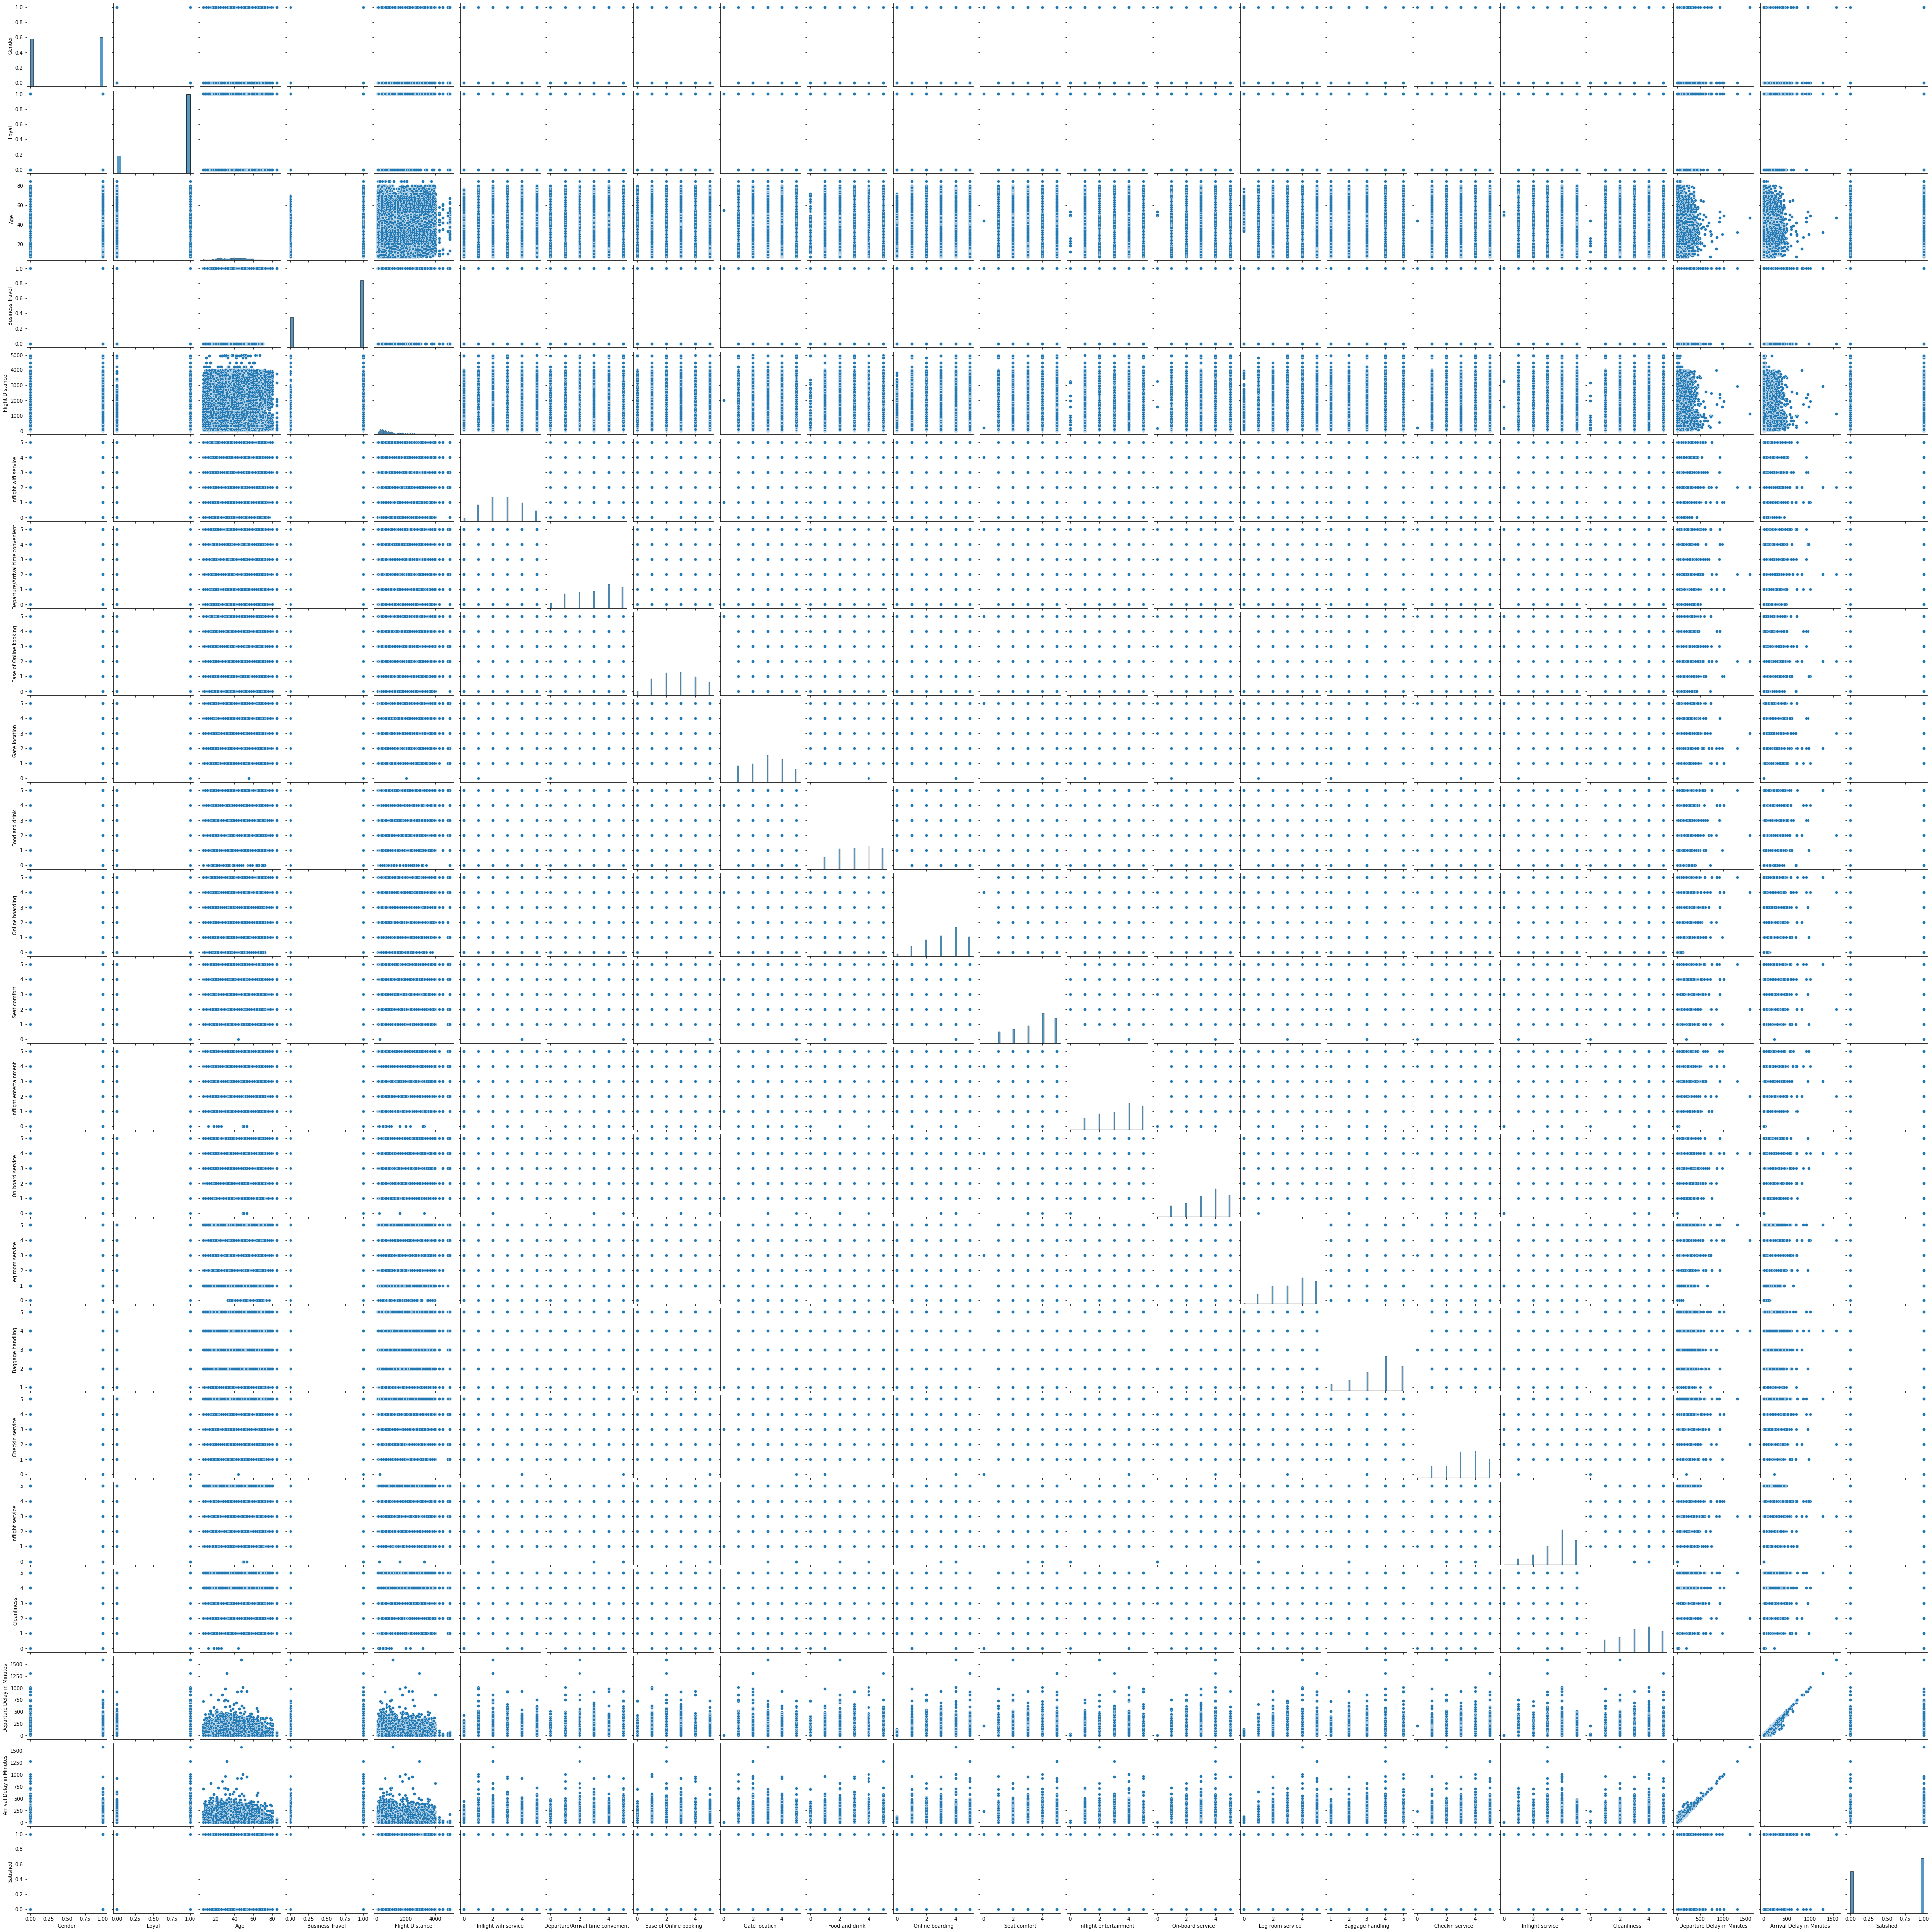

In [24]:
# Having a rough image of how numeric data are related in pairs
sns.pairplot(airline_train)

<AxesSubplot:>

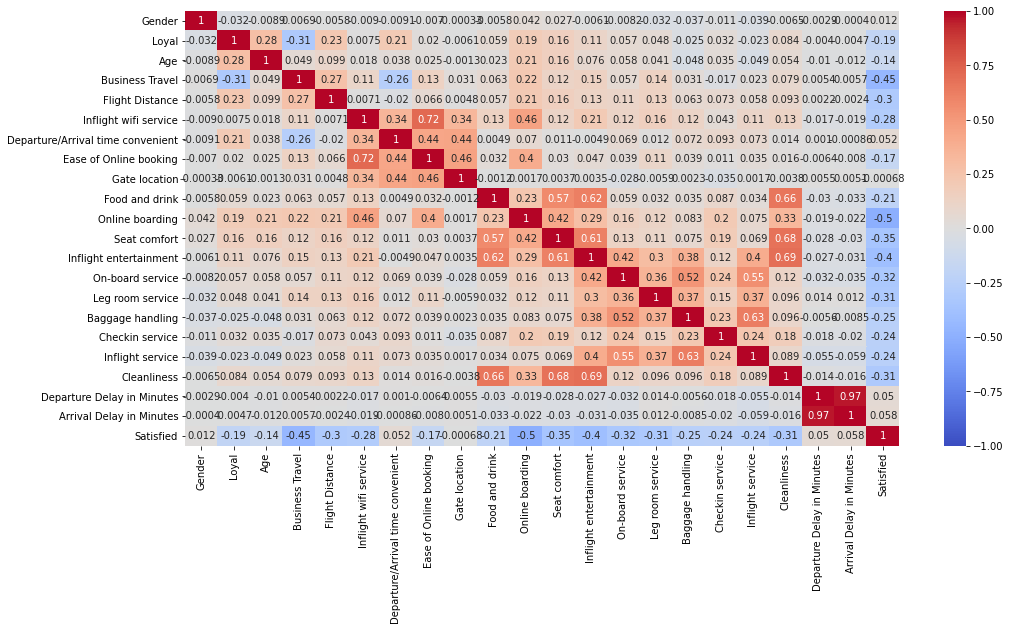

In [25]:
# Making a heatmap for the numeric data to understand how they correlate in pairs
plt.figure(figsize=(16,8))
sns.heatmap(airline_train.corr(),annot=True,cmap="coolwarm", vmin=-1)

As we can verify, there's only two columns that are very correlated with one another: `Departure Delay in Minutes` and `Arrival Delay in Minutes`, with more than 90% of correlation. **This will probably lead to multicollinearity problems.**

Therefore, it may be interesting to drop one of these columns in order to have the best prediction as possible.

I will choose to drop `Arrival Delay in Minutes` because of 2 reasons:
1. **It has 310 missing values** (opposed to `Departure Delay in Minutes` that has 0 `NaN` values)
2. **Hypothesis**: `Departure Delay in Minutes` cause more anxiety and stress because the delay is still unknown. Once the flight departs with delays, the customers had already the time to prevent other people that he is delayed and he has the whole flight duration to calm themselves and deal with the delay when arriving.

<AxesSubplot:>

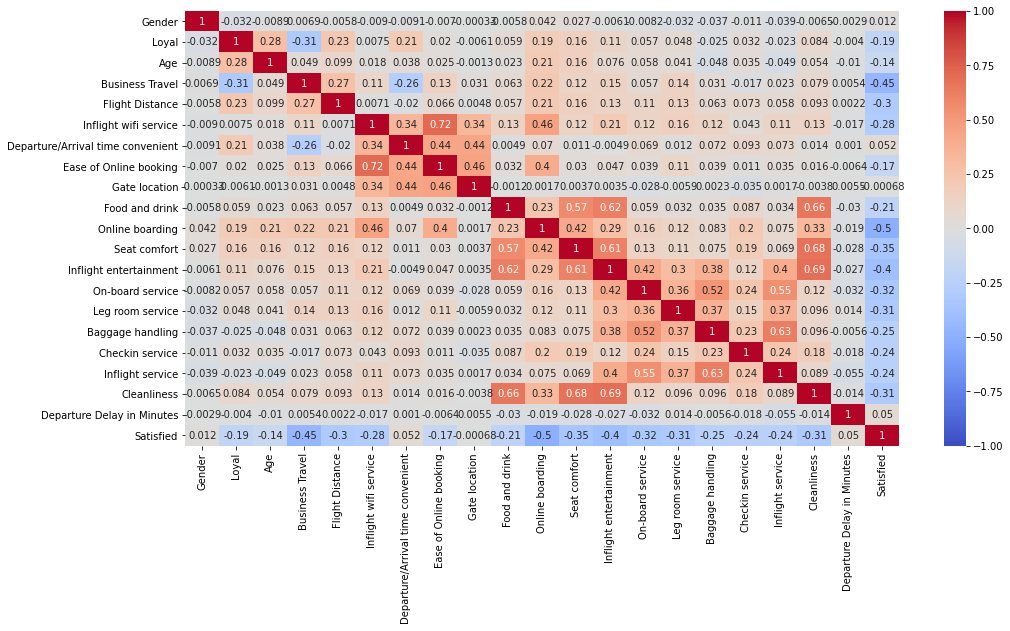

In [26]:
# Droping column "Arrival Delay in Minutes"
airline_train.drop(columns="Arrival Delay in Minutes", inplace=True)

# Printing the heatmap once again to verify that the multicollinearity problem
plt.figure(figsize=(16,8))
sns.heatmap(airline_train.corr(),annot=True,cmap="coolwarm", vmin=-1)

### Visualizing some more

Text(0.5, 1.0, 'Histogram of Ages')

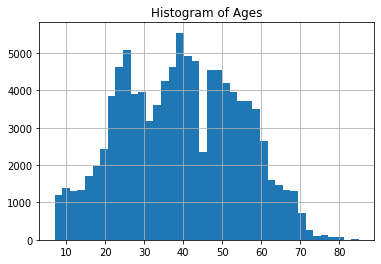

In [27]:
airline_train.Age.hist(bins=40)
plt.title("Histogram of Ages")

Text(0.5, 1.0, 'Histogram of Ages - MEN')

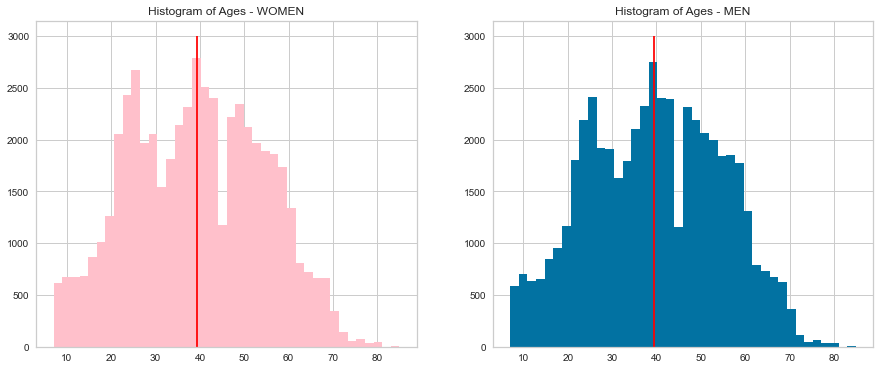

In [124]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.hist(airline_train[airline_train["Gender"]=="Female"]["Age"],bins=40,color="pink")
ax1.vlines(airline_train[airline_train["Gender"]=="Female"]["Age"].mean(),1,3000,color="red")
ax1.set_title("Histogram of Ages - WOMEN")

ax2.hist(airline_train[airline_train["Gender"]=="Male"]["Age"],bins=40)
ax2.vlines(airline_train[airline_train["Gender"]=="Male"]["Age"].mean(),1,3000,color="red")
ax2.set_title("Histogram of Ages - MEN")

Text(0.5, 1.0, 'Histogram of Flight Distance')

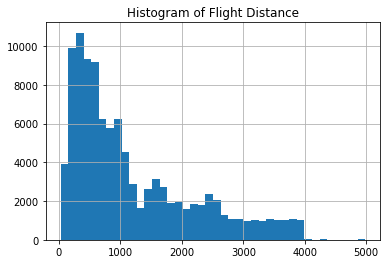

In [29]:
# Checking the distribution of Flight distance
airline_train["Flight Distance"].hist(bins=40)
plt.title("Histogram of Flight Distance")

The "Flight Distance" has a skewed distribution and may be needed to normalize in order to better work for the model.

MAXIMUM 'Flight Distance': 4983
MINIMUM 'Flight Distance': 31


{'whiskers': [<matplotlib.lines.Line2D at 0x13320d8b0>,
 'caps': [<matplotlib.lines.Line2D at 0x12c03e2e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x12c06eca0>],
 'medians': [<matplotlib.lines.Line2D at 0x133638100>],
 'fliers': [<matplotlib.lines.Line2D at 0x133638d30>],
 'means': []}

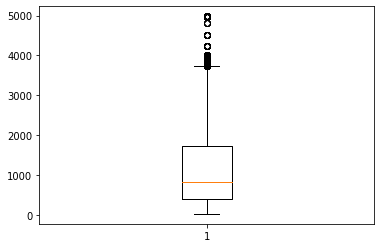

In [30]:
# Cheking outliers in "Flight Distance"
print("MAXIMUM 'Flight Distance':",airline_train["Flight Distance"].max())
print("MINIMUM 'Flight Distance':",airline_train["Flight Distance"].min())
plt.boxplot(airline_train["Flight Distance"],)

It seems that `"Flight Distance"` has also a lot of high ouliers. This should be corrected later.

MAXIMUM 'Departure Delay in Minutes': 1592
MINIMUM 'Departure Delay in Minutes': 0
58668


Text(0.5, 1.0, 'Histogram of Departure Delay in Minutes')

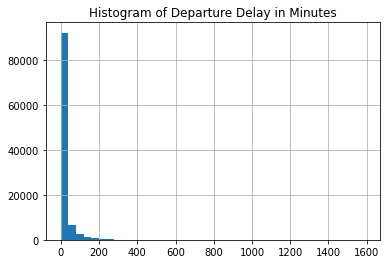

In [31]:
# Analyzing the 'Departure Delay in Minutes'
print("MAXIMUM 'Departure Delay in Minutes':",airline_train["Departure Delay in Minutes"].max())
print("MINIMUM 'Departure Delay in Minutes':",airline_train["Departure Delay in Minutes"].min())
print(airline_train["Departure Delay in Minutes"].value_counts().max())
airline_train["Departure Delay in Minutes"].hist(bins=40)
plt.title("Histogram of Departure Delay in Minutes")

This `Departure Delay in Minutes` distribution is the most skewed one, therefore it should be normalized.

MAXIMUM 'Departure Delay in Minutes': 1592
MINIMUM 'Departure Delay in Minutes': 0


{'whiskers': [<matplotlib.lines.Line2D at 0x134e12190>,
 'caps': [<matplotlib.lines.Line2D at 0x134e12850>,
 'boxes': [<matplotlib.lines.Line2D at 0x134e04df0>],
 'medians': [<matplotlib.lines.Line2D at 0x134e12f10>],
 'fliers': [<matplotlib.lines.Line2D at 0x134e1d2b0>],
 'means': []}

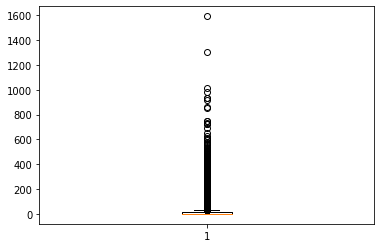

In [32]:
# Cheking outliers in "Departure Delay in Minutes"
print("MAXIMUM 'Departure Delay in Minutes':", airline_train["Departure Delay in Minutes"].max())
print("MINIMUM 'Departure Delay in Minutes':", airline_train["Departure Delay in Minutes"].min())
plt.boxplot(airline_train["Departure Delay in Minutes"])

(array([5.8668e+04, 0.0000e+00, 0.0000e+00, 2.9480e+03, 0.0000e+00,
        2.2740e+03, 0.0000e+00, 2.0090e+03, 1.8540e+03, 1.6920e+03,
        1.5170e+03, 2.6870e+03, 1.2550e+03, 3.2240e+03, 1.8620e+03,
        3.0200e+03, 1.9690e+03, 2.5880e+03, 2.5900e+03, 1.9280e+03,
        2.0810e+03, 1.8760e+03, 1.6760e+03, 1.3910e+03, 1.2210e+03,
        9.9300e+02, 7.7900e+02, 6.3700e+02, 4.7800e+02, 2.6400e+02,
        1.8100e+02, 1.2600e+02, 6.1000e+01, 2.9000e+01, 1.0000e+01,
        7.0000e+00, 2.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([0.        , 0.18433436, 0.36866872, 0.55300307, 0.73733743,
        0.92167179, 1.10600615, 1.2903405 , 1.47467486, 1.65900922,
        1.84334358, 2.02767794, 2.21201229, 2.39634665, 2.58068101,
        2.76501537, 2.94934972, 3.13368408, 3.31801844, 3.5023528 ,
        3.68668715, 3.87102151, 4.05535587, 4.23969023, 4.42402459,
        4.60835894, 4.7926933 , 4.97702766, 5.16136202, 5.34569637,
        5.53003073, 5.71436509, 5.89869945, 6.

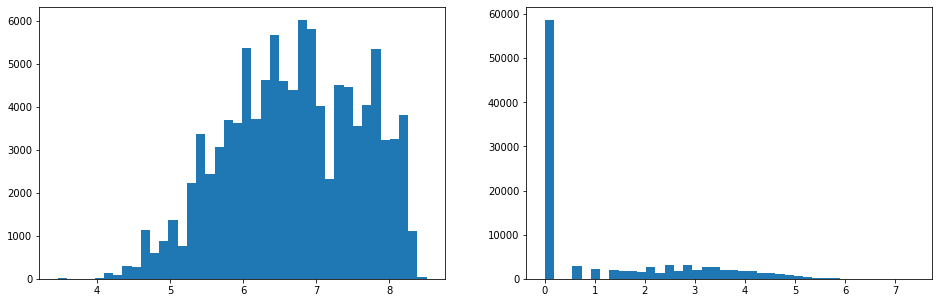

In [33]:
# Testing Feature Transformation, using the log of variables to see if I may end up with a normal distribution
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.hist(np.log(airline_train["Flight Distance"]+1),bins=40)
ax2.hist(np.log(airline_train["Departure Delay in Minutes"]+1),bins=40)

The feature transformation worked nicely for `Flight Distance`, specially because it has too many values in the hundreds kms and a few in the thousands.

But it didn't work properly for `Departure Delay in Minutes`. We may then look for another way to correct this.

## Cleaning with Features Transformation

In [34]:
# Transformint "Flight Distance" into its own log, in order to have a normal distribution
airline_train["Flight Distance"] = np.log(airline_train["Flight Distance"]+1)

## Testing: Standardizing and Scaling Variables

`"Departure Delay in Minutes"` has too many 0 values and some values that goes until the thousands.

Given that the 1st case is the most extreme, I will conduct some test to treat `"Departure Delay in Minutes"` first.

In [35]:
airline_train["Departure Delay in Minutes"].value_counts().sort_values(ascending=False)

0      58668
1       2948
2       2274
3       2009
4       1854
       ...  
444        1
329        1
579        1
314        1
447        1
Name: Departure Delay in Minutes, Length: 446, dtype: int64

### Testing the standardization first

In [36]:
# Analyzing the two previous variables standardized
from mlxtend.preprocessing import standardize

X = airline_train["Departure Delay in Minutes"]

Y = pd.DataFrame(standardize(X))

print(Y.min())
print(Y.mean())
print(Y.max())
Y.sort_values(0)

0   -0.387532
dtype: float64
0   -3.720119e-17
dtype: float64
0    41.254377
dtype: float64


/usr/local/lib/python3.9/site-packages/mlxtend/preprocessing/scaling.py:107: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]


,0
51951,-0.387532
57917,-0.387532
57919,-0.387532
57922,-0.387532
57924,-0.387532
...,...
6609,24.016928
62726,25.193992
3864,26.214114
55802,33.747324


Text(0.5, 1.0, 'Histogram of standardized values')

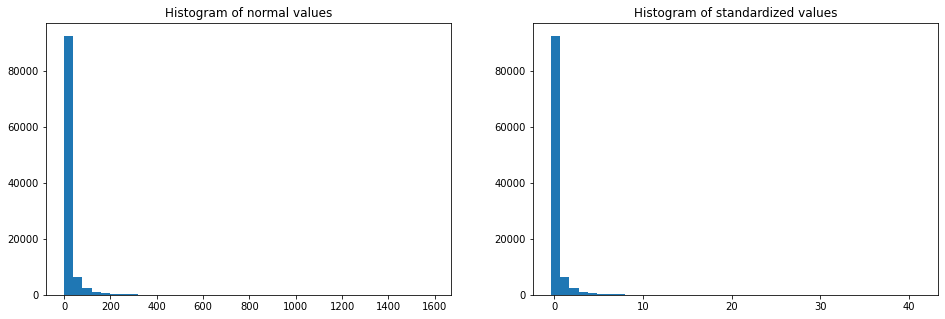

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.hist(X,bins=40)
ax1.set_title("Histogram of normal values")
ax2.hist(Y,bins=40)
ax2.set_title("Histogram of standardized values")

### Testing the normalizer

In [38]:
norm = Normalizer(X)
norm

Normalizer(norm=id
1          2
2         26
3          0
4          0
5          0
          ..
129874     0
129875     0
129878     6
129879    31
129880     0
Name: Departure Delay in Minutes, Length: 103904, dtype: int64)

### Testing the MinMaxScaler

In [39]:
# Analyzing the two previous variables scaled by MinMaxScaler
min_max_scaler = MinMaxScaler()
FD_DDM = airline_train[['Flight Distance',"Departure Delay in Minutes"]].copy()
FD_DDM_scaled = pd.DataFrame( min_max_scaler.fit_transform(FD_DDM), columns=("Flight Distance","Departure Delay in Minutes") )
FD_DDM_scaled

,Flight Distance,Departure Delay in Minutes
0,0.642996,0.001256
1,0.642996,0.016332
2,0.650561,0.000000
3,0.809592,0.000000
4,0.928334,0.000000
...,...,...
103899,0.466956,0.000000
103900,0.449186,0.000000
103901,0.466956,0.003769
103902,0.466956,0.019472


Text(0.5, 1.0, 'Histogram of Departure Delay MinMaxScaled')

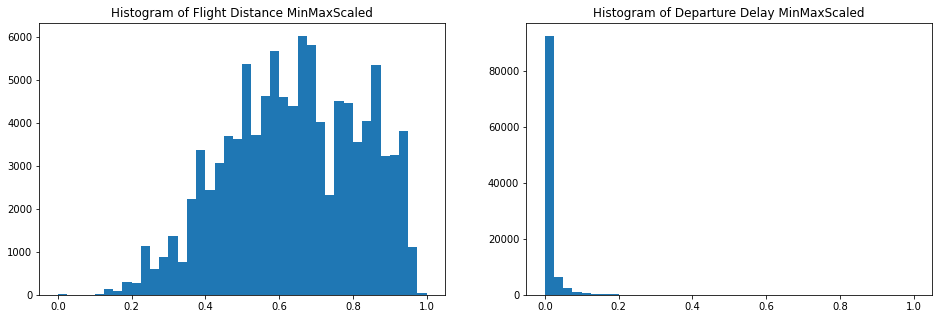

In [40]:
# Plotting histogram for new "Flight Distance"
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.hist(FD_DDM_scaled["Flight Distance"],bins=40)
ax1.set_title("Histogram of Flight Distance MinMaxScaled")
ax2.hist(FD_DDM_scaled["Departure Delay in Minutes"],bins=40)
ax2.set_title("Histogram of Departure Delay MinMaxScaled")

As we can see, all the treatments before didn't eliminate our outliers for `Departure Delay in Minutes`.

Plus, we don't want them to be eliminated since a delay of days are important to consider theur impact in the customer satisfaction.

In conclusion, **the best solution will be to create BINS for this variable.**

## Creating bins for `Departure Delay in Minutes`

I will try to create categories of equal stressed/upset people by considering intervals of their `Departure Delay`, assuming these interval comprehend equally levels of stress/deception for a delayed flight: 

- **No_delay**: up to 10min delay $\longrightarrow$ PERFECT SITUATION

- **10_to_40min_delay**: Delay from 10min to 40min $\longrightarrow$ acceptable delay but some stress and anxiety

- **41_to_120min_delay**: Delay from 21min to 60min $\longrightarrow$ significant stress and anxiety

- **121_240min_delay**: Delay from 61min to 3h $\longrightarrow$ high stress and anxiety bordeline intolerable

- **241_450min_delay**: Delay from 3h1min to 7,5h $\longrightarrow$ intolerable stress and anxiety

- **more_than_450min_delay**: Delay from 7,5h to 60min $\longrightarrow$ **not forgivable customer** with intolerable stress and anxiety because of lost of days of vacation, but they might already have the possibility to go home, go to the hotel or have a walk at the city before coming back to the airport

In [41]:
def delay_transformation(x):
    if x<=10:
        x = "less_than_10min"
    elif x<=40:
        x = "10_to_40min"
    elif x<=120:
        x = "41_to_120min"
    elif x<=240:
        x = "121_240min"
    elif x<=450:
        x = "241_450min"
    else:
        x = "more_than_450min"

    return x

hide_toggle()

In [42]:
# Testing the transformation to understand the sizes of our bins
airline_train["Departure Delay in Minutes"].apply(delay_transformation).value_counts()/airline_train.shape[0]

less_than_10min     0.731935
10_to_40min         0.159840
41_to_120min        0.083779
121_240min          0.019845
241_450min          0.004129
more_than_450min    0.000472
Name: Departure Delay in Minutes, dtype: float64

In [43]:
# Applying the previous transformation
airline_train["Departure Delay in Minutes"] = airline_train["Departure Delay in Minutes"].apply(delay_transformation)

# Renaming the column for something more succint
airline_train.rename(columns={"Departure Delay in Minutes":"Departure_Delay"},inplace=True)

## Creating dummies for the categorical variables

In [44]:
airline_train.dtypes

Gender                                 int64
Loyal                                  int64
Age                                    int64
Business Travel                        int64
Class                                 object
Flight Distance                      float64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure_Delay                       object
Satisfied                              int64
dtype: obj

After all the cleaning, there's only 2 categorical variables to treat: `Class` and `Departure Delay in Minutes`

In [45]:
pd.options.display.max_columns=40
pd.get_dummies(airline_train, columns=["Class","Departure_Delay"],drop_first=True)

,Gender,Loyal,Age,Business Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Satisfied,Class_Eco,Class_Eco Plus,Departure_Delay_121_240min,Departure_Delay_241_450min,Departure_Delay_41_to_120min,Departure_Delay_less_than_10min,Departure_Delay_more_than_450min
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,48,1,6.711740,3,3,3,3,5,3,5,5,3,2,5,4,5,5,1,0,0,0,0,0,1,0
2,1,1,35,1,6.711740,2,2,2,2,3,5,4,5,5,5,5,3,5,5,0,0,0,0,0,0,0,0
3,0,1,41,1,6.749931,4,4,4,4,5,5,5,3,3,3,3,4,3,5,0,0,0,0,0,0,1,0
4,0,1,50,1,7.552762,2,2,2,2,4,4,5,5,5,5,5,3,5,4,0,0,0,0,0,0,1,0
5,1,1,49,1,8.152198,3,3,3,3,4,5,4,3,3,4,3,3,3,5,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129874,1,1,28,0,5.823046,4,2,4,4,3,4,3,3,1,5,3,4,4,3,1,0,1,0,0,0,1,0
129875,1,1,55,0,5.733341,3,4,3,4,2,4,3,4,4,3,4,4,4,4,1,0,1,0,0,0,1,0
129878,0,1,42,0,5.823046,2,5,2,1,3,2,3,3,3,4,5,4,4,3,1,0,1,0,0,0,1,0


In [46]:
airline_train = pd.get_dummies(airline_train, columns=["Class","Departure_Delay"],drop_first=True)

## Compiling all cleaning and features transformation in functions, in order to use for the `TEST` dataset next

In [127]:
def clean_dataset(df,transform_dataset=True):
    
    # Droping column "Unnamed: 0" because it doesn't bring important information
    df.drop(columns="Unnamed: 0", inplace=True)

    # Reseting index for "id" since these values are unique for each row:
    df.set_index("id", inplace=True)

    # Gender : 1 for Female and 0 for Male
    df.Gender = df.Gender.apply(lambda x: 1 if x=="Female" else 0)
    
    # Sorting by the index, in order to have a cleaner structure
    df.sort_values(by="id",inplace=True)
    
    # Cleaning column "Customer Type" to indicate only if customer is loyal or not
    df.rename(columns={"Customer Type":"Loyal"}, inplace=True)
    df["Loyal"] = df["Loyal"].apply(lambda x: 1 if x=='Loyal Customer' else 0)
    
    # Cleaning column "Satisfaction" to indicate only if customer was satisfied or not
    df.rename(columns={"satisfaction":"Dissatisfied"}, inplace=True)
    df["Dissatisfied"] = df["Dissatisfied"].apply(lambda x: 1 if x=='neutral or dissatisfied' else 0)
    
    # Cleaning column "Type of Travel" to indicate only is a Business Traveler or not
    df.rename(columns={'Type of Travel':"Business Travel"}, inplace=True)
    df["Business Travel"] = df["Business Travel"].apply(lambda x: 1 if x=='Business travel' else 0)
    
    if transform_dataset==True:
        # Transforming "Flight Distance" into its own log, in order to have a normal distribution
        df["Flight Distance"] = np.log(df["Flight Distance"]+1)

        # Applying the delay_transformation function
        df["Departure Delay in Minutes"] = df["Departure Delay in Minutes"].apply(delay_transformation)
    
        # Renaming the column for something more succint
        df.rename(columns={"Departure Delay in Minutes":"Departure_Delay"},inplace=True)

        # Droping column "Arrival Delay in Minutes"
        df.drop(columns="Arrival Delay in Minutes", inplace=True)

        # Creating dummies for the 2 categorical columns remaining "Class" and "Departure_Delay"
        df = pd.get_dummies(df, columns=["Class","Departure_Delay"],drop_first=True)
    
    return df
    
hide_toggle()

## `TEST` dataset

Finally, we may use our `TEST` dataset, in order to predict the customer satisfaction based on the client's usage of the service.

In [48]:
airline_test = pd.read_csv("data/airline-test.csv")
print(airline_test.shape)
airline_test.head(5)

(25976, 25)


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,satisfied


In [49]:
airline_test.dtypes

Unnamed: 0                             int64
id                                     int64
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure 

In [50]:
airline_test.isna().sum()

Unnamed: 0                            0
id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0


As on the `TRAIN` dataset, the `TEST` dataset only has missing values on the `Arrival Delay in Minutes`, approving the use of all the clean_dataset function created before.

### Cleaning the `TEST` dataset:

In [51]:
airline_test = clean_dataset(airline_test)

In [52]:
airline_test.head()

,Gender,Loyal,Age,Business Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Satisfied,Class_Eco,Class_Eco Plus,Departure_Delay_121_240min,Departure_Delay_241_450min,Departure_Delay_41_to_120min,Departure_Delay_less_than_10min,Departure_Delay_more_than_450min
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
17,1,1,48,0,6.711740,2,3,2,3,1,5,1,5,5,2,5,5,5,2,1,1,0,0,0,0,1,0
20,1,1,42,0,6.711740,3,3,3,4,1,3,4,1,1,3,1,3,1,3,1,1,0,0,0,0,1,0
35,0,1,39,1,7.422374,2,2,2,2,5,4,5,3,3,4,5,5,3,5,0,0,0,0,0,0,0,0
44,0,1,51,1,7.639161,4,1,4,4,2,5,5,5,5,5,5,5,5,4,0,0,0,0,0,0,1,0
49,0,0,20,1,4.691348,4,5,4,1,5,4,3,5,5,4,5,5,4,5,1,1,0,0,0,0,1,0


## Models Creation and Prediction

Given that the `TRAIN` and `TEST` datasets were given there's no need to generate these samples by spliting of a whole dataset.

Splitting `TRAIN` dataset into **X (features)** and **Y (target)**:

In [53]:
X_airline_train = airline_train.drop(columns='Dissatisfied').copy()
print(X_airline_train.shape)

Y_airline_train = airline_train['Dissatisfied'].copy()
print(Y_airline_train.shape)

(103904, 26)
(103904,)


In [54]:
# Counting the repartition of target variables:
Y_airline_train.value_counts()/Y_airline_train.shape[0]

1    0.566667
0    0.433333
Name: Satisfied, dtype: float64

Splitting `TEST` dataset into **X (features)** and **Y (target)**:

In [55]:
X_airline_test = airline_test.drop(columns='Dissatisfied').copy()
print(X_airline_test.shape)
Y_airline_test = airline_test['Dissatisfied'].copy()
print(Y_airline_test.shape)

(25976, 26)
(25976,)


In [56]:
Y_airline_test.value_counts()/Y_airline_test.shape[0]

1    0.561018
0    0.438982
Name: Satisfied, dtype: float64

For this exercice, let's use 3 different models and see which one performs better:

1. **Logistic Regression**
2. **K Nearest Neighbors**
3. **Catboost**

### Logistic Regression

In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
# Model creation
log_model = LogisticRegression(max_iter = 1e5)

# Model fitting for our TRAIN dataset
log_model.fit(X_airline_train, Y_airline_train)

LogisticRegression(max_iter=100000.0)

In [59]:
# Predicting results for the test sample
Y_pred_log = log_model.predict(X_airline_test)

In [60]:
# PRINTING THE RESULTS: confusion matrix, accuracy score, precision score, recall score and f1_score
display(pd.DataFrame(confusion_matrix(Y_airline_test,Y_pred_log),
             columns=["Y_pred_satisfied","Y_pred_dissatisfied"],
             index=["Y_satisfied","Y_dissatisfied"],))
print()
print(f"Accuracy score: {accuracy_score(Y_airline_test, Y_pred_log)*100:0.1f}%")
print(f"Precision score: {precision_score(Y_airline_test, Y_pred_log)*100:0.1f}%")
print(f"Recall score: {recall_score(Y_airline_test, Y_pred_log)*100:0.1f}%")
print(f"F1 score: {f1_score(Y_airline_test, Y_pred_log)*100:0.1f}%")

,Y_pred_satisfied,Y_pred_dissatisfied
Y_satisfied,9501,1902
Y_dissatisfied,1442,13131



Accuracy score: 87.1%
Precision score: 87.3%
Recall score: 90.1%
F1 score: 88.7%


As we can see, the model has a good performance, with 87% accuracy.

However, there's a high number of False positive: 1441 (representing 13,2% of dissatisfied customers predicted).

Nevertheless what really matter is the `False Negative` because they might be clients that may churn.

This segment represents: 1903 clients.

<AxesSubplot:>

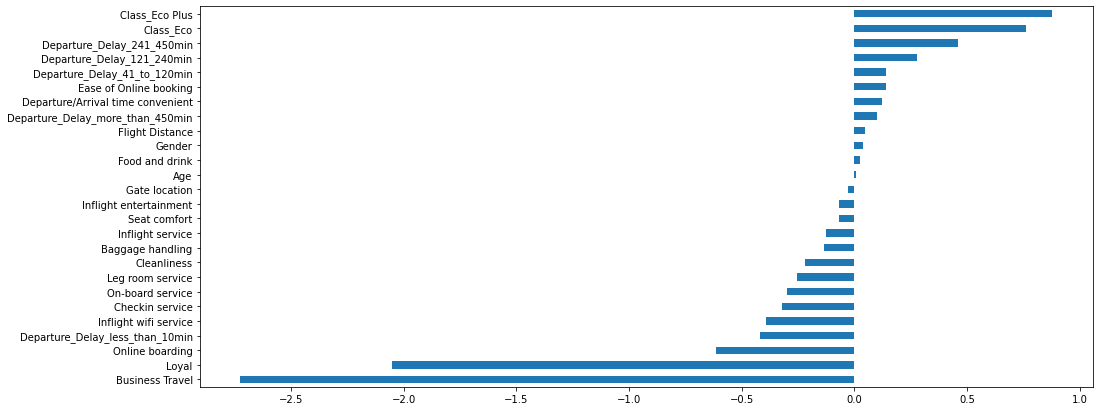

In [61]:
# Summarizing the most import attributes considered by this logistic regression
pd.Series(log_model.coef_[0],index=X_airline_train.columns).sort_values().plot.barh(figsize=(16,7))

In [79]:
N, train_score, val_score = learning_curve(log_model,
                                           X_airline_train, Y_airline_train, cv=4, scoring='f1',
                                          train_sizes=np.linspace(0.1, 1,10))
plt.figure(figsize(16,6))
plt.plot(N, train_score.mean(axis=1), label="Train score")
plt.plot(N, val_score.mean(axis=1), label="Validation score")
plt.legend()

KeyboardInterrupt: 

### K Nearest Neighbors

In [62]:
from sklearn.neighbors import KNeighborsClassifier

In [63]:
# Model creation
knn_model = KNeighborsClassifier(3)

# Model fitting for our training dataset
knn_model.fit(X_airline_train, Y_airline_train)

KNeighborsClassifier(n_neighbors=3)

In [64]:
# Predicting dissatisfied customers
Y_pred_knn = knn_model.predict(X_airline_test)

In [65]:
# PRINTING THE RESULTS: confusion matrix, accuracy score, precision score, recall score and f1_score
display(pd.DataFrame(confusion_matrix(Y_airline_test,Y_pred_knn),
             columns=["Y_pred_satisfied","Y_pred_dissatisfied"],
             index=["Y_satisfied","Y_dissatisfied"],))
print()
print(f"Accuracy score: {accuracy_score(Y_airline_test, Y_pred_knn)*100:0.1f}%")
print(f"Precision score: {precision_score(Y_airline_test, Y_pred_knn)*100:0.1f}%")
print(f"Recall score: {recall_score(Y_airline_test, Y_pred_knn)*100:0.1f}%")
print(f"F1 score: {f1_score(Y_airline_test, Y_pred_knn)*100:0.1f}%")

,Y_pred_satisfied,Y_pred_dissatisfied
Y_satisfied,9966,1437
Y_dissatisfied,866,13707



Accuracy score: 91.1%
Precision score: 90.5%
Recall score: 94.1%
F1 score: 92.3%


This model is more performing than the previous one, with more precision and accuracy.

Therefore, significant less `False Negatives`.

In [ ]:
N, train_score, val_score = learning_curve(knn_model,
                                           X_airline_train, Y_airline_train, cv=4, scoring='f1',
                                          train_sizes=np.linspace(0.1, 1,10))
plt.figure(figsize(16,6))
plt.plot(N, train_score.mean(axis=1), label="Train score")
plt.plot(N, val_score.mean(axis=1), label="Validation score")
plt.legend()

### Decision Tree

In [66]:
from sklearn.tree import DecisionTreeClassifier

In [67]:
# Model creation
decisiontree_model = DecisionTreeClassifier()

# Model fitting for our training dataset
decisiontree_model.fit(X_airline_train, Y_airline_train)

# Predicting dissatisfied customers
Y_pred_decisiontree = decisiontree_model.predict(X_airline_test)

In [68]:
# PRINTING THE RESULTS: confusion matrix, accuracy score, precision score, recall score and f1_score
display(pd.DataFrame(confusion_matrix(Y_airline_test,Y_pred_decisiontree),
             columns=["Y_pred_satisfied","Y_pred_dissatisfied"],
             index=["Y_satisfied","Y_dissatisfied"],))
print()
print(f"Accuracy score: {accuracy_score(Y_airline_test, Y_pred_decisiontree)*100:0.1f}%")
print(f"Precision score: {precision_score(Y_airline_test, Y_pred_decisiontree)*100:0.1f}%")
print(f"Recall score: {recall_score(Y_airline_test, Y_pred_decisiontree)*100:0.1f}%")
print(f"F1 score: {f1_score(Y_airline_test, Y_pred_decisiontree)*100:0.1f}%")

,Y_pred_satisfied,Y_pred_dissatisfied
Y_satisfied,10716,687
Y_dissatisfied,763,13810



Accuracy score: 94.4%
Precision score: 95.3%
Recall score: 94.8%
F1 score: 95.0%


<AxesSubplot:>

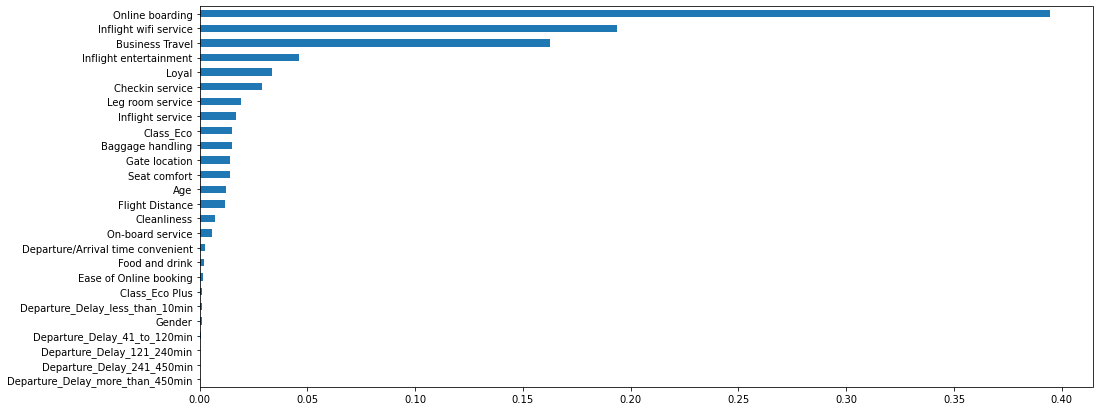

In [74]:
# Summarizing the most import attributes considered by the decision tree classification
pd.Series(decisiontree_model.feature_importances_,index=X_airline_train.columns).sort_values().plot.barh(figsize=(16,7))

Looking at the maximum depth to understand if our model is overfitting:

In [70]:
print(decisiontree_model.tree_.max_depth)

36


The previous number is very high and makes me worry with overfitting problems. Therefore, I will limit the `max_depth` to **15 levels**.

In [71]:
# Model creation
decisiontree_model = DecisionTreeClassifier(max_depth=15)

# Model fitting for our training dataset
decisiontree_model.fit(X_airline_train, Y_airline_train)

# Predicting dissatisfied customers
Y_pred_decisiontree = decisiontree_model.predict(X_airline_test)

# PRINTING THE RESULTS: confusion matrix, accuracy score, precision score, recall score and f1_score
display(pd.DataFrame(confusion_matrix(Y_airline_test,Y_pred_decisiontree),
             columns=["Y_pred_satisfied","Y_pred_dissatisfied"],
             index=["Y_satisfied","Y_dissatisfied"],))
print()
print(f"Accuracy score: {accuracy_score(Y_airline_test, Y_pred_decisiontree)*100:0.1f}%")
print(f"Precision score: {precision_score(Y_airline_test, Y_pred_decisiontree)*100:0.1f}%")
print(f"Recall score: {recall_score(Y_airline_test, Y_pred_decisiontree)*100:0.1f}%")
print(f"F1 score: {f1_score(Y_airline_test, Y_pred_decisiontree)*100:0.1f}%")

,Y_pred_satisfied,Y_pred_dissatisfied
Y_satisfied,10694,709
Y_dissatisfied,514,14059



Accuracy score: 95.3%
Precision score: 95.2%
Recall score: 96.5%
F1 score: 95.8%


We may see that our model has improved its overall scores.

#### The decision tree model worked neatly and so far has been the best model. This can be explained by the fact that the database contains a lot of categorical variables, being the perfect case for applying this model. However this model can be slower and can produce overfitting.

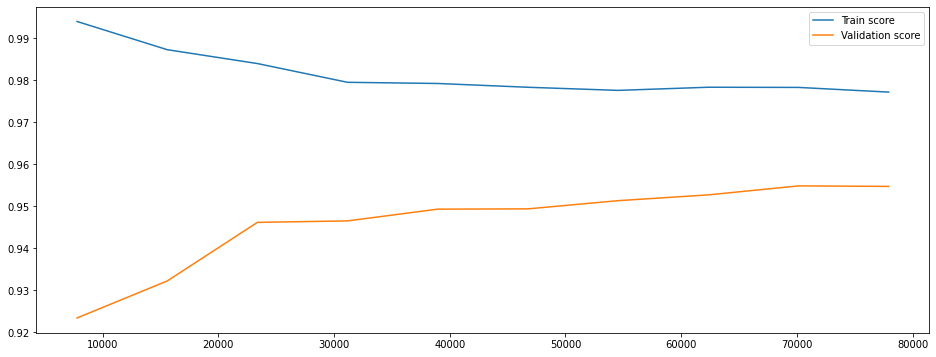

In [81]:
N, train_score, val_score = learning_curve(decisiontree_model,
                                           X_airline_train, Y_airline_train, cv=4, scoring='f1',
                                          train_sizes=np.linspace(0.1, 1,10))
plt.figure(figsize=(16,6))
plt.plot(N, train_score.mean(axis=1), label="Train score")
plt.plot(N, val_score.mean(axis=1), label="Validation score")
plt.legend()

In [1]:
from sklearn import tree
tree.plot_tree(decisiontree_model)
#fig = plt.figure(figsize=(25,20))
#tree.plot_tree(decisiontree_model)

NameError: name 'decisiontree_model' is not defined

## Clustering

Considerign that we have more than **100k datapoints**, we are limited in the models that we may use in this case. Therefore, let's ignore "Affinity Propagation", "Agglomerative", "Spectral".

And let's use: **K-means** (Sklearn or Scipy) and **DBSCAN** (from Sklearn as well).

### Kmeans Clustering

In [121]:
from sklearn.cluster import KMeans

In [122]:
from yellowbrick.cluster import KElbowVisualizer

In [100]:
# Creation of the model
kmeans_model = KMeans(n_clusters=5)

# Fitting the model
kmeans_model.fit(airline_train)

KMeans(n_clusters=5)

In [101]:
# Obtaining the clusters
kmeans_model.labels_

array([3, 0, 0, ..., 0, 3, 1], dtype=int32)

In [128]:
# Creating a new dataset with each cluster
airline_train_cluster = clean_dataset(pd.read_csv("data/airline-train.csv"),False)

airline_train_cluster["Cluster_KMeans"] = kmeans_model.labels_

airline_train_cluster

,Gender,Loyal,Age,Business Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Dissatisfied,Cluster_KMeans
id,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,48,1,Business,821,3,3,3,3,5,3,5,5,3,2,5,4,5,5,2,5.0,1,3
2,1,1,35,1,Business,821,2,2,2,2,3,5,4,5,5,5,5,3,5,5,26,39.0,0,0
3,0,1,41,1,Business,853,4,4,4,4,5,5,5,3,3,3,3,4,3,5,0,0.0,0,0
4,0,1,50,1,Business,1905,2,2,2,2,4,4,5,5,5,5,5,3,5,4,0,0.0,0,3
5,1,1,49,1,Business,3470,3,3,3,3,4,5,4,3,3,4,3,3,3,5,0,1.0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129874,1,1,28,0,Eco Plus,337,4,2,4,4,3,4,3,3,1,5,3,4,4,3,0,0.0,1,4
129875,1,1,55,0,Eco Plus,308,3,4,3,4,2,4,3,4,4,3,4,4,4,4,0,0.0,1,3
129878,0,1,42,0,Eco Plus,337,2,5,2,1,3,2,3,3,3,4,5,4,4,3,6,14.0,1,0


In [129]:
# Looking at the different clusters created:
airline_train_cluster.groupby("Cluster_KMeans").mean()

,Gender,Loyal,Age,Business Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Dissatisfied
Cluster_KMeans,,,,,,,,,,,,,,,,,,,,,,
0,0.503569,0.821676,38.821676,0.782016,1240.814465,2.777834,3.018316,2.788939,2.987850,3.209078,3.323154,3.505012,3.431894,3.441304,3.441953,3.640720,3.311364,3.649120,3.308588,14.900238,15.355527,0.511646
1,0.510897,0.790435,14.460337,0.363805,916.168799,2.613606,3.251566,2.613959,2.973882,3.063708,2.657902,3.025765,3.088591,3.207271,3.198006,3.685697,3.205771,3.695050,3.082149,15.195712,15.720786,0.803759
2,0.501988,0.959112,62.499404,0.541484,1148.535388,2.662094,3.234195,2.712922,2.944665,3.175679,3.405699,3.548973,3.311067,3.337641,3.239231,3.471637,3.286879,3.480649,3.266998,14.151093,14.397806,0.622531
3,0.503659,0.945713,50.218342,0.758591,1379.153794,2.798003,3.101098,2.830258,2.992603,3.260102,3.647152,3.740694,3.559656,3.557708,3.524260,3.657453,3.419782,3.660834,3.421771,14.477171,14.727429,0.424038
4,0.517499,0.606601,26.229259,0.755945,1088.631804,2.700500,2.871143,2.738629,2.969595,3.215032,2.940450,3.180806,3.222145,3.244787,3.210642,3.669078,3.234340,3.682615,3.228812,15.298646,15.669507,0.630991


<AxesSubplot:xlabel='Age', ylabel='Flight Distance'>

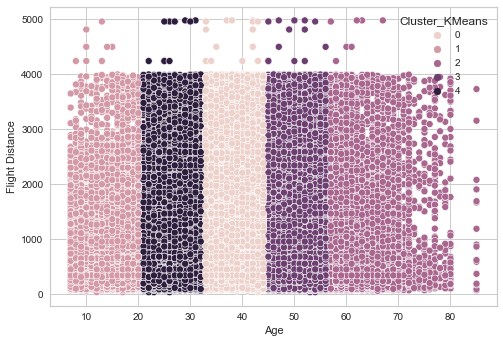

In [130]:
# Visualizing my clusters
sns.scatterplot(data=airline_train_cluster, x="Age",y="Flight Distance",hue="Cluster_KMeans")

In [131]:
airline_train_cluster.columns

Index(['Gender', 'Loyal', 'Age', 'Business Travel', 'Class', 'Flight Distance',
       'Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'Cleanliness',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'Dissatisfied', 'Cluster_KMeans'],
      dtype='object')

<AxesSubplot:xlabel='Age', ylabel='Departure Delay in Minutes'>

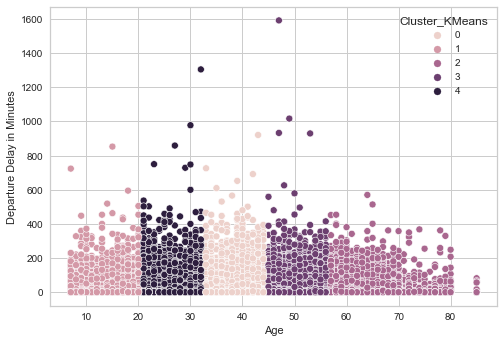

In [137]:
# Visualizing my clusters
sns.scatterplot(data=airline_train_cluster, y="Departure Delay in Minutes",x="Age",hue="Cluster_KMeans")

In [ ]:
# Visualizing the 
visualizer=KElbowVisualizer(kmeans_model, k=(2,10), metric='silhouette')
visualizer.fit(airline_test)
visualizer.poof()

### DBSCAN clustering

In [104]:
from sklearn.cluster import DBSCAN

In [149]:
X_airline_train.columns

Index(['Gender', 'Loyal', 'Age', 'Business Travel', 'Flight Distance',
       'Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'Cleanliness', 'Class_Eco',
       'Class_Eco Plus', 'Departure_Delay_121_240min',
       'Departure_Delay_241_450min', 'Departure_Delay_41_to_120min',
       'Departure_Delay_less_than_10min', 'Departure_Delay_more_than_450min'],
      dtype='object')

In [167]:
# Model creation
dbscan_model = DBSCAN(eps=1)

# Model fitting
dbscan_model.fit(X_airline_train[["Gender","Loyal","Age","Business Travel","Flight Distance",'Ease of Online booking','Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service']])

# Storing the result in a column of our new DataFrame
airline_train_cluster["Cluster_DBSCAN"] = dbscan_model.labels_

In [171]:
len(dbscan_model.labels_)

103904

In [168]:
len(set(dbscan_model.labels_))

4

In [173]:
# Looking at the different clusters created:
airline_train_cluster.groupby("Cluster_DBSCAN").mean()

,Gender,Loyal,Age,Business Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Dissatisfied,Cluster_KMeans
Cluster_DBSCAN,,,,,,,,,,,,,,,,,,,,,,,
-1,0.507436,0.817295,39.37798,0.689582,1189.41064,2.729644,3.060334,2.756866,2.976879,3.202158,3.250171,3.439315,3.358065,3.382273,3.350961,3.63178,3.30419,3.640376,3.286315,14.815996,15.179032,0.566749,2.072635
0,1.000000,1.000000,56.00000,1.000000,580.00000,4.000000,3.400000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.00000,4.00000,4.000000,3.800000,0.000000,1.200000,0.000000,3.000000
1,1.000000,1.000000,39.00000,1.000000,2255.00000,1.000000,1.000000,1.000000,1.000000,3.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.00000,5.00000,4.000000,3.400000,17.600000,24.400000,0.000000,0.000000
2,0.000000,1.000000,59.00000,1.000000,1517.40000,4.000000,4.000000,4.000000,4.000000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00000,3.00000,4.000000,3.400000,19.000000,12.600000,0.000000,2.000000
